In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "drive/MyDrive/Redes Neuronales/TPs/TP2/PhC-C2DH-U373.zip"

Archive:  drive/MyDrive/Redes Neuronales/TPs/TP2/PhC-C2DH-U373.zip
   creating: PhC-C2DH-U373/
   creating: PhC-C2DH-U373/01/
  inflating: PhC-C2DH-U373/01/t000.tif  
  inflating: PhC-C2DH-U373/01/t001.tif  
  inflating: PhC-C2DH-U373/01/t002.tif  
  inflating: PhC-C2DH-U373/01/t003.tif  
  inflating: PhC-C2DH-U373/01/t004.tif  
  inflating: PhC-C2DH-U373/01/t005.tif  
  inflating: PhC-C2DH-U373/01/t006.tif  
  inflating: PhC-C2DH-U373/01/t007.tif  
  inflating: PhC-C2DH-U373/01/t008.tif  
  inflating: PhC-C2DH-U373/01/t009.tif  
  inflating: PhC-C2DH-U373/01/t010.tif  
  inflating: PhC-C2DH-U373/01/t011.tif  
  inflating: PhC-C2DH-U373/01/t012.tif  
  inflating: PhC-C2DH-U373/01/t013.tif  
  inflating: PhC-C2DH-U373/01/t014.tif  
  inflating: PhC-C2DH-U373/01/t015.tif  
  inflating: PhC-C2DH-U373/01/t016.tif  
  inflating: PhC-C2DH-U373/01/t017.tif  
  inflating: PhC-C2DH-U373/01/t018.tif  
  inflating: PhC-C2DH-U373/01/t019.tif  
  inflating: PhC-C2DH-U373/01/t020.tif  
  inflating: 

In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

# Cargo Train y Val

Train será aumentado

In [2]:
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [3]:
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))  # Para poder stackear luego
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

In [4]:
train_images = np.vstack(train_images)/255    # Normalización
train_masks = 1*(np.vstack(train_masks) > 0)  # Para detector binario
val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) > 0)

# Imágenes de train sin aumentar
Se muestra la máscara de anotación sobre la imagen original con algo de transparencia para poder ver las detecciones.

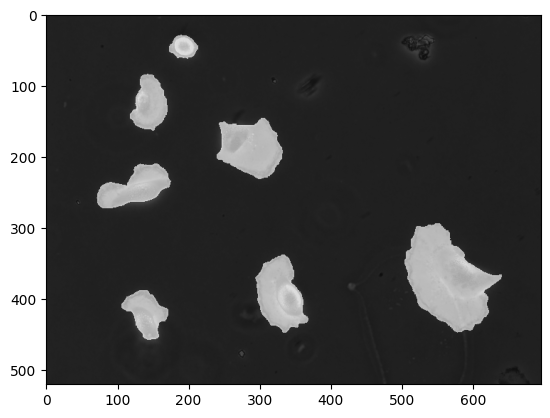

In [ ]:
idx = 100
plt.imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")
plt.imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.6)
plt.show()

# Armo datasets de tensorflow y aumento

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que de descompondrán durante el entrenamiento.

Se podría usar *albumentations* pero se probaron las capas de augmentation de TF porque corren en la GPU. El problema es que no se encontró cómo hacer que operen sobre los datos de validación, así que se optó por esta alternativa.

In [5]:
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)

In [ ]:
x_train[0,:,:,0].max()

0.7137254901960784

In [ ]:
len(x_train)

115

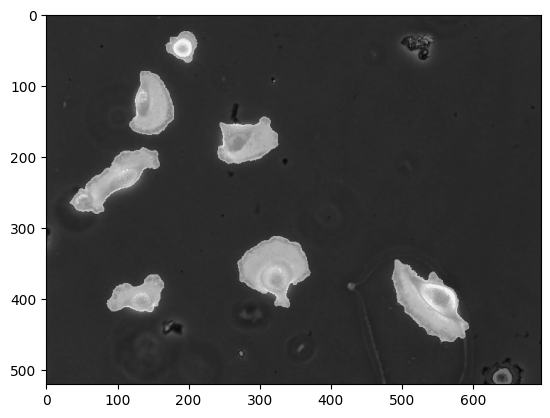

In [ ]:
plt.imshow(x_train[0,:,:,0], cmap="gray")
plt.imshow(x_train[0,:,:,1], cmap="gray", alpha = 0.5)

In [6]:
from tensorflow.keras.models import Sequential

# Armo una red mínima fully convolutional con Atrous Convolutions

No hay que modificar nunca el tamaño de la imagen. Lo trival es usar muchas capas sin max pooling con padding same. El problema es que el campo perceptual crece linealmente, y se necesitarán muchas capas para llegar a la cantidad de pixeles que por ejemplo puede ocupar una célula. Luego, la U-Net permitirá aplicar max pooling para reducir la cantidad de capas.

Es fully convolutional, asi que no es necesario indicar el tamaño de la imagen de entrada (`input_shape=(None,None,1)`).

Se usa dilation rate para hacer crecer el campo perceptual sin modificar el tamaño de las imágenes.

Necesitamos salida sigmoidea, porque al final es una clasificacion binaria entre célula y no célula, con binary cross entropy.

In [ ]:
filters = 16
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])


# Armo la red de preprocesamiento para hacer aumentación en la GPU que no tengo

Gracias a que la aumentación ocurra en una red que es parte de la estructura general de entrenamiento, cada epoch consistirá en 115 imágenes modificadas. Es decir, en vez de aumentar el dataset y luego entrenar, la aumentación ocurre "on the fly".

In [7]:
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        # tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

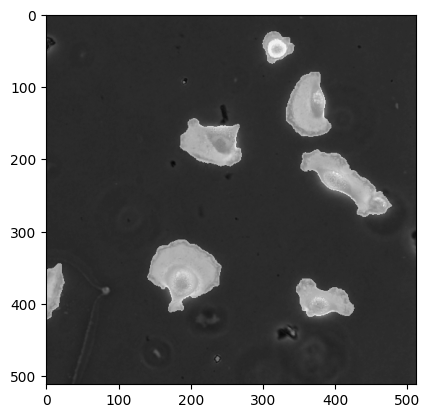

In [ ]:
preproc = get_preproc()
aux_elem = preproc(x_train[0])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

In [8]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [9]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val, loss="bin_cross"):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.loss = loss


    def call(self, inputs):
        #img_mask = self.red_preproc = red_preproc(inputs)
        return self.red_segmentacion(inputs[:,:,:1])

    @tf.function
    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            data_aug = self.red_preproc(data)
            loss = self._compute_loss(data_aug)
            #print(K.mean(loss))

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    @tf.function
    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        #aux = self.red_preproc(data)
        mask_out = self.red_segmentacion(data[:,:,:,:1])
        #print(mask_out.shape)
        #print(data[:,:,:,1:2].numpy())
        if self.loss == "dice":
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out)
        return loss

    # property
    # def metrics(self):
    #     # We need to list our metrics here so the `reset_states()` can be
    #     # called automatically.
    #     return [self.loss_tracker]

In [ ]:
red_falopa = get_red_seg()

In [ ]:
red_falopa.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

In [ ]:
preproc= get_preproc()
preproc_val = get_preproc_val()
red_falopa = get_red_seg()
model = SegmentationModel(preproc, red_falopa, preproc_val)

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [ ]:
len(x_val)

115

Se manda concatenado train y val porque la red recibe todo como un mismo vector, y se configura el validation split en 0.5. La documentación aclara que no se hace shuffle, por lo que se divide correctamente.

In [ ]:
history = model.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 74s 2s/step - loss: 0.6997 - val_loss: 0.6831
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 0.6685 - val_loss: 0.6092
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 0.5374 - val_loss: 0.2721
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.3607 - val_loss: 0.1695
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 0.3431 - val_loss: 0.2400
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 0.3388 - val_loss: 0.1979
Epoch 7/100
8/8 [==============================] - 9s 1s/step - loss: 0.3315 - val_loss: 0.1887
Epoch 8/100
8/8 [==============================] - 9s 1s/step - loss: 0.3265 - val_loss: 0.2014
Epoch 9/100
8/8 [==============================] - 9s 1s/step - loss: 0.3272 - val_loss: 0.1935
Epoch 10/100
8/8 [==============================] - 9s 1s/step - loss: 0.3099 - val_loss: 0.1905
Epoch 11/100
8/8 [====================

KeyboardInterrupt: ignored

Despues de todo el entrenamiento nos quedamos solo con la red de segmentación para hacer predicciones, si bien el entrenamiento usa la red de pre-procesamiento.

In [ ]:
pred = red_falopa(x_val[0:1,:,:,0])
pred.shape

TensorShape([1, 520, 696, 1])

In [ ]:
pred.numpy().max()

0.957254

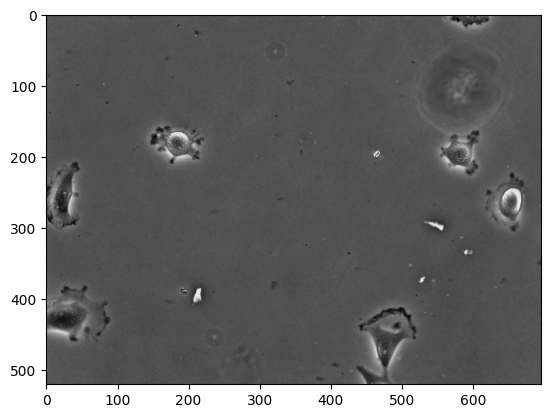

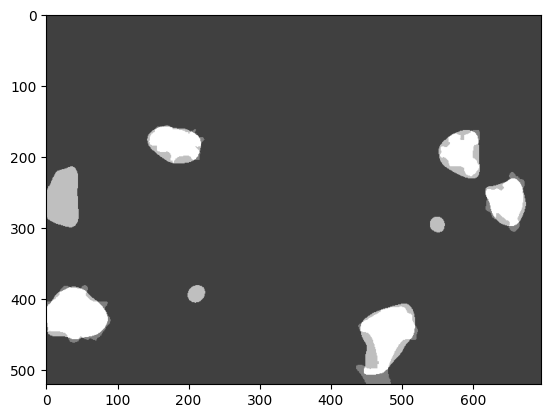

In [ ]:
plt.imshow(x_val[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

In [10]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose

El bloque principal que se instanciará en la U-Net es el `conv_block`, que se muestra en la siguiente figura. Los bloques convolucionales están siempre, mientras que los marcados con naranja son opcionales y dependientes de los parametros de la función.

Están las opciones de BN y Dropout, aunque está contraindicado utilizar ambos al mismo tiempo. Si se habilita el parámetro `res`, se concatena la entrada a la salida, buscando aprender el residuo en lugar de la transferencia completa. Esto se ha visto beneficioso con respecto al problema de *vanishing gradient*, y a nivel eficiencia del entrenamiento ya que se comienza a entrenar desde la identidad y no desde la transferencia nula.

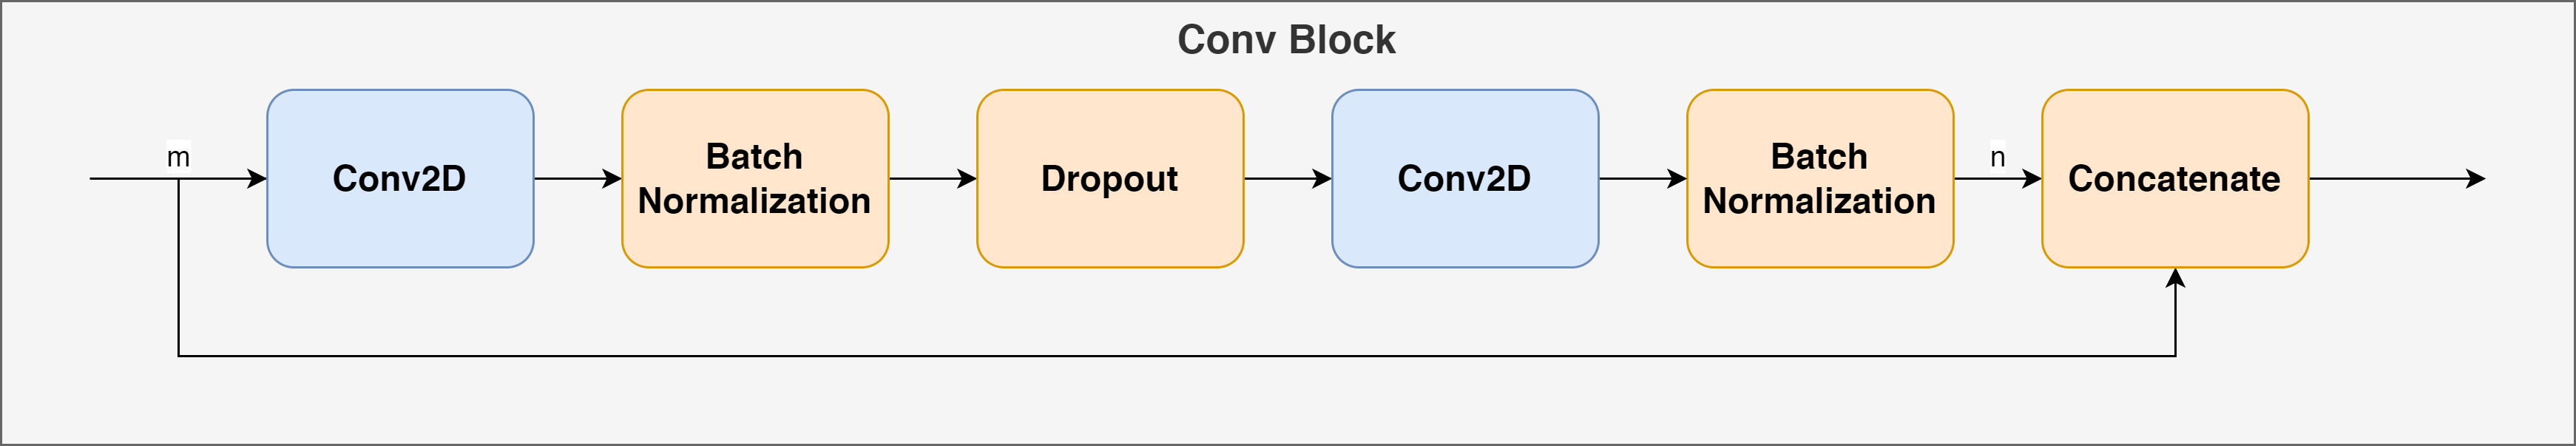

Luego, está la función recursiva `level_block`. Ésta es responsable de la estructura de la U-Net, generando instancias de `conv_block` adecuadamente. La recursión se puede resumir en los siguientes pasos:
* Crea el primer bloque convolucional que recibe la entrada.
* Realiza el paso de reducción de tamaño, ya sea por **Max Pooling** o una convolucional con stride 2.
* Se llama a si misma, repitiendo los pasos anteriores hasta llegar a la profundidad especificada en `depth`, reduciendo cada vez más el tamaño de la imagen.
* Cuando se llega al fondo, se crea el último bloque de la bajada y comienza la subida.
* Ahora debe ir creciendo el tamaño de la imagen para igualar las dimensiones para cada nivel. Esto se puede hacer con **UpSampling** o una convolucional transpuesta.
* Se concatena la salida del bloque de profundidad $i$ con la que está subiendo del nivel $i+1$, recuperando la información espacial que se perdió al bajar de nivel.
* Se crea el bloque que recibe ambas salidas, el cual luego alimentará al del nivel superior, hasta llegar al nivel inicial saliendo de la recursión.

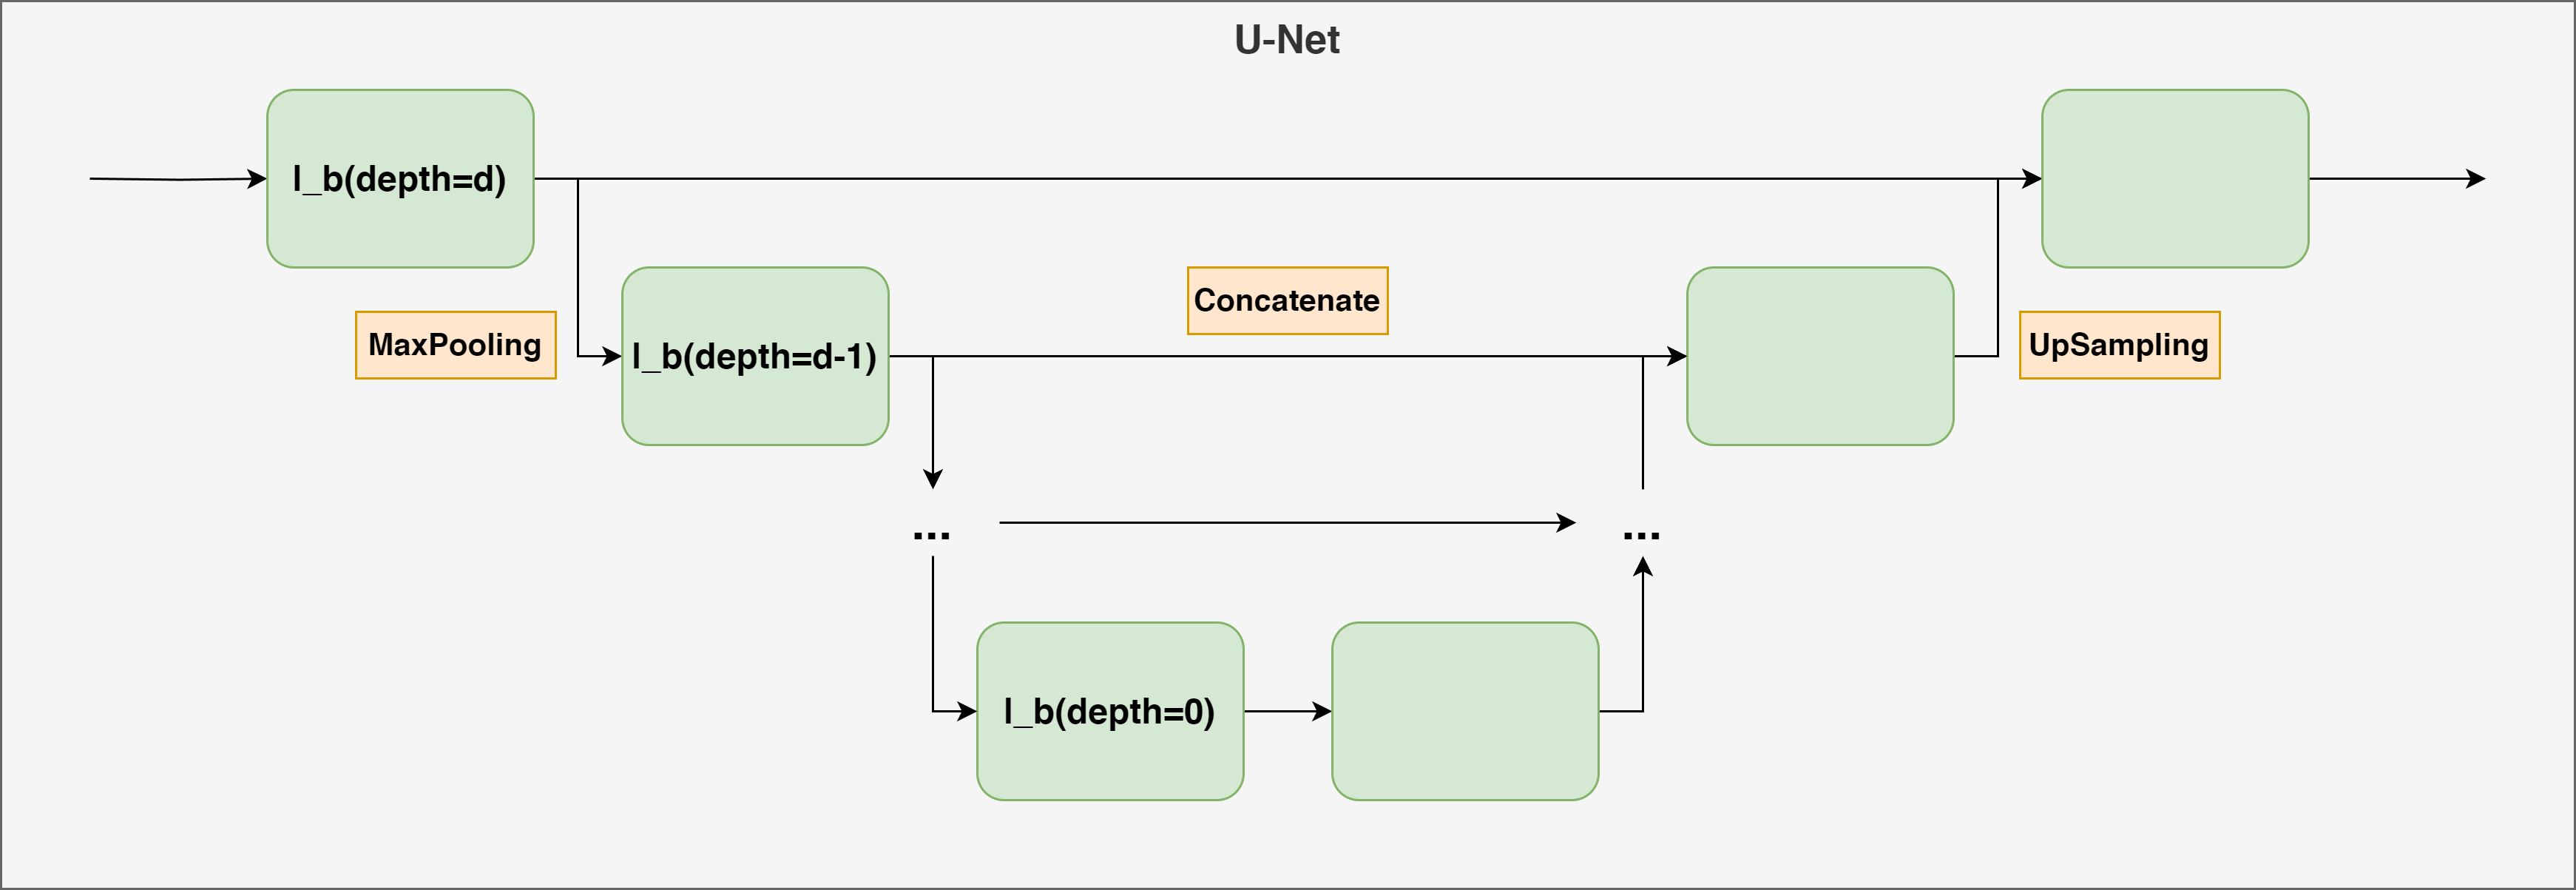

La función `UNet` se encarga de realizar el primer llamado a `level_block` con los parámetros seleccionados, y de agregar la capa de entrada y una última `Conv2D` con activación sigmoidea para la salida.

In [11]:
img_shape = (512, 512, 1)
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [12]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [13]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(5e-4))

Agrego los siguientes callbacks para intentar de mejorar el entrenamiento

In [14]:
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.2,
                                                patience=5)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10,
                                                mode='min',
                                                restore_best_weights=True,
                                                min_delta=0.001,
                                                verbose=True)

## Prueba con 2 fits: loss binary cross y luego dice

In [18]:
history = model_unet.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=100, validation_split = 0.5, callbacks=[reduceLr, earlyStopping], verbose = 1)

Epoch 1/100
15/15 [==============================] - 51s 1s/step - loss: 0.4708 - val_loss: 0.2558 - lr: 5.0000e-04
Epoch 2/100
15/15 [==============================] - 11s 751ms/step - loss: 0.3346 - val_loss: 0.1983 - lr: 5.0000e-04
Epoch 3/100
15/15 [==============================] - 11s 758ms/step - loss: 0.3211 - val_loss: 0.1935 - lr: 5.0000e-04
Epoch 4/100
15/15 [==============================] - 11s 760ms/step - loss: 0.3163 - val_loss: 0.2521 - lr: 5.0000e-04
Epoch 5/100
15/15 [==============================] - 11s 772ms/step - loss: 0.2846 - val_loss: 0.1156 - lr: 5.0000e-04
Epoch 6/100
15/15 [==============================] - 12s 781ms/step - loss: 0.2132 - val_loss: 0.2532 - lr: 5.0000e-04
Epoch 7/100
15/15 [==============================] - 12s 786ms/step - loss: 0.1873 - val_loss: 0.0722 - lr: 5.0000e-04
Epoch 8/100
15/15 [==============================] - 12s 790ms/step - loss: 0.1346 - val_loss: 0.0590 - lr: 5.0000e-04
Epoch 9/100
15/15 [==============================] 

In [19]:
model_unet.loss = "dice"

In [20]:
history = model_unet.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=100, validation_split = 0.5, callbacks=[reduceLr, earlyStopping], verbose = 1)

Epoch 1/100
15/15 [==============================] - 12s 837ms/step - loss: 0.0130 - val_loss: 0.0200
Epoch 2/100
15/15 [==============================] - 12s 786ms/step - loss: 0.0122 - val_loss: 0.0203
Epoch 3/100
15/15 [==============================] - 12s 784ms/step - loss: 0.0128 - val_loss: 0.0203
Epoch 4/100
15/15 [==============================] - 12s 791ms/step - loss: 0.0119 - val_loss: 0.0203
Epoch 5/100
15/15 [==============================] - 12s 786ms/step - loss: 0.0123 - val_loss: 0.0202
Epoch 6/100
15/15 [==============================] - 12s 783ms/step - loss: 0.0122 - val_loss: 0.0203
Epoch 7/100
15/15 [==============================] - 12s 784ms/step - loss: 0.0126 - val_loss: 0.0200
Epoch 8/100
15/15 [==============================] - 12s 785ms/step - loss: 0.0120 - val_loss: 0.0201
Epoch 9/100
15/15 [==============================] - 12s 790ms/step - loss: 0.0119 - val_loss: 0.0202
Epoch 10/100
15/15 [==============================] - 12s 785ms/step - loss: 0.012

In [21]:
red_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [22]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

In [23]:
pred.numpy().max()

0.99999857

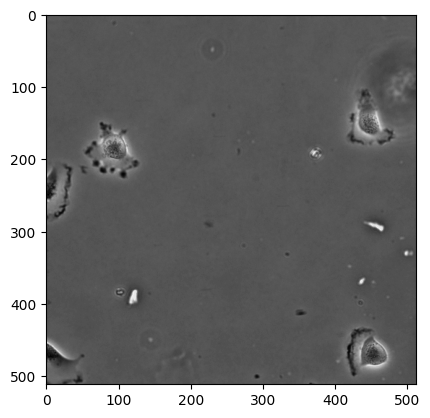

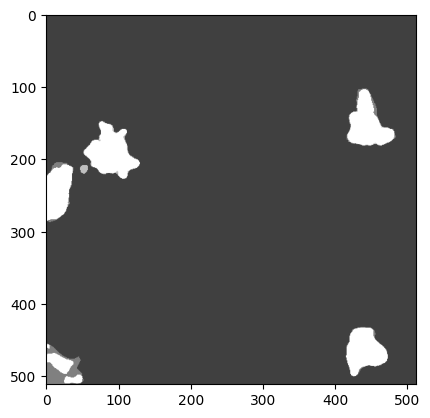

In [27]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

## Prueba con loss `dice`

In [16]:
model_unet.loss = "dice"

In [19]:
history = model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, callbacks=[reduceLr, earlyStopping], verbose = 1)

Epoch 1/100
8/8 [==============================] - 61s 3s/step - loss: 0.8453 - val_loss: 0.9324 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 12s 1s/step - loss: 0.8359 - val_loss: 0.9310 - lr: 1.0000e-04
Epoch 3/100
8/8 [==============================] - 14s 2s/step - loss: 0.8319 - val_loss: 0.9288 - lr: 1.0000e-04
Epoch 4/100
8/8 [==============================] - 14s 2s/step - loss: 0.8264 - val_loss: 0.9285 - lr: 1.0000e-04
Epoch 5/100
8/8 [==============================] - 12s 2s/step - loss: 0.8211 - val_loss: 0.9273 - lr: 1.0000e-04
Epoch 6/100
8/8 [==============================] - 14s 2s/step - loss: 0.8190 - val_loss: 0.9253 - lr: 1.0000e-04
Epoch 7/100
8/8 [==============================] - 12s 2s/step - loss: 0.8167 - val_loss: 0.9173 - lr: 1.0000e-04
Epoch 8/100
8/8 [==============================] - 12s 2s/step - loss: 0.7921 - val_loss: 0.8952 - lr: 1.0000e-04
Epoch 9/100
8/8 [==============================] - 12s 2s/step - loss: 0.7492 - val_loss

In [20]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

In [21]:
pred.numpy().max()

1.0

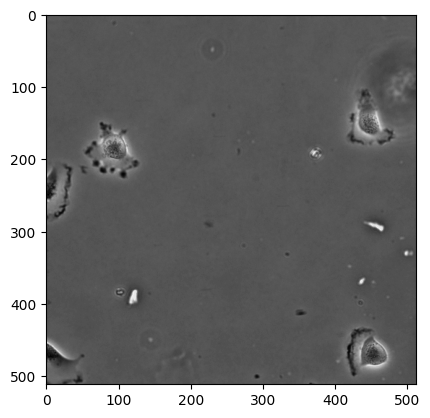

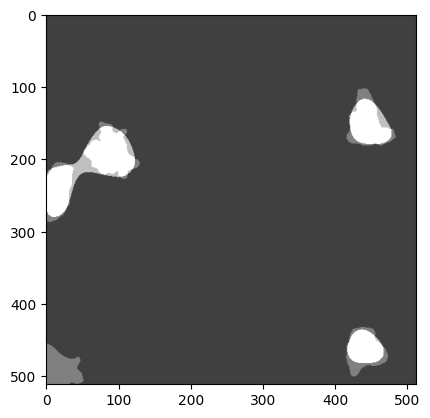

In [29]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha=0.5)
plt.show()

## Prueba sin residuo, binary cross, bs 16

In [12]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = False
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [13]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(5e-4))

In [16]:
history = model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, callbacks=[reduceLr, earlyStopping], verbose = 1)

Epoch 1/100
8/8 [==============================] - 42s 2s/step - loss: 0.6767 - val_loss: 0.6155 - lr: 5.0000e-04
Epoch 2/100
8/8 [==============================] - 7s 940ms/step - loss: 0.4839 - val_loss: 0.4092 - lr: 5.0000e-04
Epoch 3/100
8/8 [==============================] - 6s 752ms/step - loss: 0.4213 - val_loss: 0.1735 - lr: 5.0000e-04
Epoch 4/100
8/8 [==============================] - 7s 960ms/step - loss: 0.3525 - val_loss: 0.1693 - lr: 5.0000e-04
Epoch 5/100
8/8 [==============================] - 7s 942ms/step - loss: 0.3370 - val_loss: 0.1760 - lr: 5.0000e-04
Epoch 6/100
8/8 [==============================] - 6s 796ms/step - loss: 0.3166 - val_loss: 0.1799 - lr: 5.0000e-04
Epoch 7/100
8/8 [==============================] - 7s 949ms/step - loss: 0.3111 - val_loss: 0.1802 - lr: 5.0000e-04
Epoch 8/100
8/8 [==============================] - 7s 942ms/step - loss: 0.3065 - val_loss: 0.1929 - lr: 5.0000e-04
Epoch 9/100
8/8 [==============================] - 6s 753ms/step - loss: 0

In [17]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

In [18]:
pred.numpy().max()

0.4783299

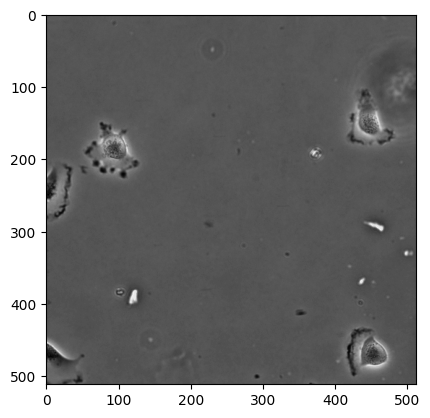

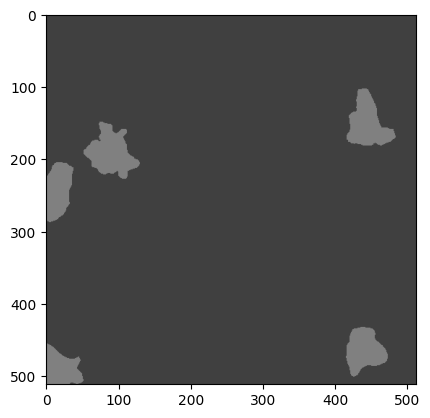

In [22]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

## Prueba con random rotation en la data aug

In [15]:
history = model_unet.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=100, validation_split = 0.5, callbacks=[reduceLr, earlyStopping], verbose = 1)

Epoch 1/100
15/15 [==============================] - 50s 1s/step - loss: 0.4836 - val_loss: 0.1855 - lr: 5.0000e-04
Epoch 2/100
15/15 [==============================] - 12s 803ms/step - loss: 0.3495 - val_loss: 0.1936 - lr: 5.0000e-04
Epoch 3/100
15/15 [==============================] - 12s 804ms/step - loss: 0.3349 - val_loss: 0.2236 - lr: 5.0000e-04
Epoch 4/100
15/15 [==============================] - 14s 981ms/step - loss: 0.3083 - val_loss: 0.1554 - lr: 5.0000e-04
Epoch 5/100
15/15 [==============================] - 14s 976ms/step - loss: 0.2001 - val_loss: 0.0778 - lr: 5.0000e-04
Epoch 6/100
15/15 [==============================] - 12s 812ms/step - loss: 0.1124 - val_loss: 0.0510 - lr: 5.0000e-04
Epoch 7/100
15/15 [==============================] - 14s 984ms/step - loss: 0.1057 - val_loss: 0.0477 - lr: 5.0000e-04
Epoch 8/100
15/15 [==============================] - 14s 986ms/step - loss: 0.0968 - val_loss: 0.0664 - lr: 5.0000e-04
Epoch 9/100
15/15 [==============================] 

In [16]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

In [17]:
pred.numpy().max()

0.99928904

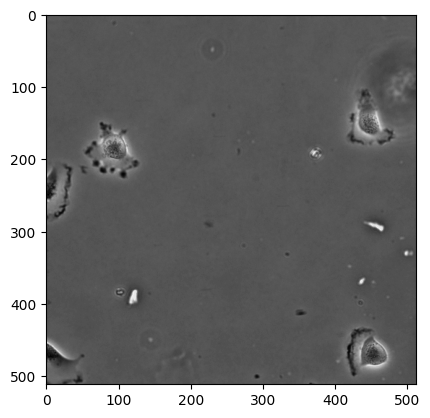

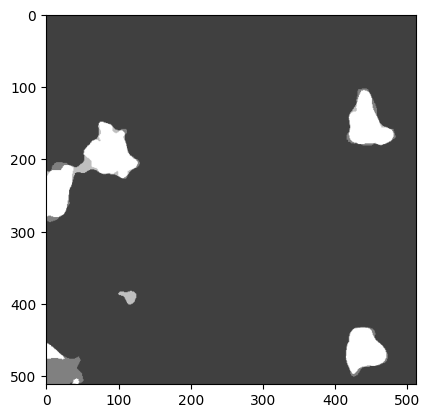

In [20]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

## Conv2D transpose en lugar de UpSampling

In [12]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = False,
    upconv=False
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [13]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(5e-4))

In [15]:
history = model_unet.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=100, validation_split = 0.5, callbacks=[reduceLr, earlyStopping], verbose = 1)

Epoch 1/100
15/15 [==============================] - 32s 787ms/step - loss: 0.6159 - val_loss: 0.3807 - lr: 5.0000e-04
Epoch 2/100
15/15 [==============================] - 5s 355ms/step - loss: 0.3742 - val_loss: 0.2772 - lr: 5.0000e-04
Epoch 3/100
15/15 [==============================] - 5s 344ms/step - loss: 0.3372 - val_loss: 0.2398 - lr: 5.0000e-04
Epoch 4/100
15/15 [==============================] - 5s 349ms/step - loss: 0.3159 - val_loss: 0.1640 - lr: 5.0000e-04
Epoch 5/100
15/15 [==============================] - 5s 368ms/step - loss: 0.2782 - val_loss: 0.1142 - lr: 5.0000e-04
Epoch 6/100
15/15 [==============================] - 5s 350ms/step - loss: 0.2259 - val_loss: 0.0896 - lr: 5.0000e-04
Epoch 7/100
15/15 [==============================] - 7s 454ms/step - loss: 0.1773 - val_loss: 0.0627 - lr: 5.0000e-04
Epoch 8/100
15/15 [==============================] - 6s 378ms/step - loss: 0.3256 - val_loss: 0.0991 - lr: 5.0000e-04
Epoch 9/100
15/15 [==============================] - 5s

In [16]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

In [17]:
pred.numpy().max()

0.99999976

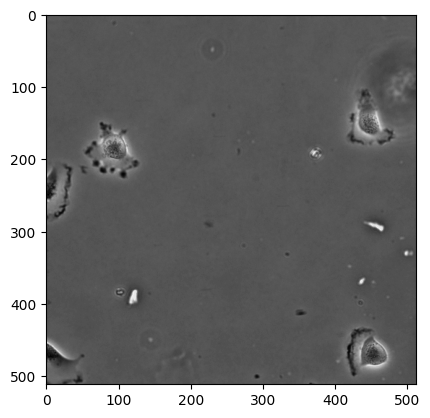

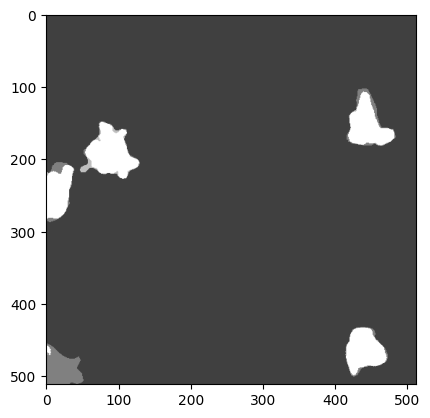

In [18]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()